
## Chapter 6: Kernel Methods

Reference [[95](#1)].

Import libraries and  initialize:

In [7]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import BasicAer

q = QuantumRegister(4)
c = ClassicalRegister(4)
backend = BasicAer.get_backend('qasm_simulator')

 Define training and test sets with the following training instances of the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris):

In [8]:
training_set = [[0, 1], [0.78861006, 0.61489363]]
labels = [0, 1]
test_set = [[-0.549, 0.836], [0.053 , 0.999]]

 Define amplitude encoding, 

In [9]:
test_angles = [4.30417579487669/2, 3.0357101997648965/2]
training_angle = 1.3245021469658966/4

Define the state preparation function. 

In [10]:
def prepare_state(q, c, angles):
    ancilla_qubit = q[0]
    index_qubit = q[1]
    data_qubit = q[2]
    class_qubit = q[3]
    circuit = QuantumCircuit(q, c)
    # Put the ancilla and the index qubits into uniform superposition
    circuit.h(ancilla_qubit)
    circuit.h(index_qubit)

    # Prepare the test vector
    circuit.cx(ancilla_qubit, data_qubit)
    circuit.u3(-angles[0], 0, 0, data_qubit)
    circuit.cx(ancilla_qubit, data_qubit)
    circuit.u3(angles[0], 0, 0, data_qubit)
    # Flip the ancilla qubit > this moves the input 
    # vector to the |0> state of the ancilla
    circuit.x(ancilla_qubit)
    circuit.barrier()

    # Prepare the first training vector
    # [0,1] -> class 0
    # We can prepare this with a Toffoli
    circuit.ccx(ancilla_qubit, index_qubit, data_qubit)
    # Flip the index qubit > moves the first training vector to the 
    # |0> state of the index qubit
    circuit.x(index_qubit)
    circuit.barrier()

    # Prepare the second training vector
    # [0.78861, 0.61489] -> class 1

    circuit.ccx(ancilla_qubit, index_qubit, data_qubit)
    circuit.cx(index_qubit, data_qubit)
    circuit.u3(angles[1], 0, 0, data_qubit)
    circuit.cx(index_qubit, data_qubit)
    circuit.u3(-angles[1], 0, 0, data_qubit)
    circuit.ccx(ancilla_qubit, index_qubit, data_qubit)
    circuit.cx(index_qubit, data_qubit)
    circuit.u3(-angles[1], 0, 0, data_qubit)
    circuit.cx(index_qubit, data_qubit)
    circuit.u3(angles[1], 0, 0, data_qubit)
    circuit.barrier()

    # Flip the class label for training vector #2
    circuit.cx(index_qubit, class_qubit)
    circuit.barrier()
    return circuit

The circuit for preparing state with the first test instance:

In [11]:
from qiskit.tools.visualization import circuit_drawer
angles = [test_angles[0], training_angle]
state_preparation_0 = prepare_state(q, c, angles)
circuit_drawer(state_preparation_0)

┌───┐                                   ┌───┐        ░            ░      »
q1_0: ┤ H ├──■───────────────────────■────────┤ X ├────────░───■────────░───■──»
      ├───┤  │                       │        └───┘        ░   │  ┌───┐ ░   │  »
q1_1: ┤ H ├──┼───────────────────────┼─────────────────────░───■──┤ X ├─░───■──»
      └───┘┌─┴─┐┌─────────────────┐┌─┴─┐┌────────────────┐ ░ ┌─┴─┐└───┘ ░ ┌─┴─┐»
q1_2: ─────┤ X ├┤ U3(-2.1521,0,0) ├┤ X ├┤ U3(2.1521,0,0) ├─░─┤ X ├──────░─┤ X ├»
           └───┘└─────────────────┘└───┘└────────────────┘ ░ └───┘      ░ └───┘»
q1_3: ─────────────────────────────────────────────────────░────────────░──────»
                                                           ░            ░      »
c1: 4/═════════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                 »
«q1_0: ───────────────────────────────────────────────────■───────»
«                                                         │       »
«q1_1: ──■───────────────────────■────────────────────────■────■──»
«      ┌─┴─┐┌─────────────────┐┌─┴─┐┌──────────────────┐┌─┴─┐┌─┴─┐»
«q1_2: ┤ X ├┤ U3(0.33113,0,0) ├┤ X ├┤ U3(-0.33113,0,0) ├┤ X ├┤ X ├»
«      └───┘└─────────────────┘└───┘└──────────────────┘└───┘└───┘»
«q1_3: ───────────────────────────────────────────────────────────»
«                                                                 »
«c1: 4/═══════════════════════════════════════════════════════════»
«                                                                 »
«                                                   ░       ░ 
«q1_0: ─────────────────────────────────────────────░───────░─
«                                                   ░       ░ 
«q1_1: ──────────────────────■──────────────────────░───■───░─
«      ┌──────────────────┐┌─┴─┐┌─────────────────┐ ░   │   ░ 
«q1_2: ┤ U3(-0.33113,0,0) ├┤ X ├┤ U3(0.33113,0,0) ├─░───┼───░─
«      └──────────────────┘└───┘└─────────────────┘ ░ ┌─┴─┐ ░ 
«q1_3: ─────────────────────────────────────────────░─┤ X ├─░─
«                                                   ░ └───┘ ░ 
«c1: 4/═══════════════════════════════════════════════════════
«

Kernel on a shallow circuit

In [12]:
def interfere_data_and_test_instances(circuit, q, c, angles):
    circuit.h(q[0])
    circuit.barrier()
    circuit.measure(q, c)
    return circuit

A measurement of the ancilla gives the outcome probability of observing 0 as $\frac{1}{4N}\sum_{i=1}^N |x_t + x_i|^2$. This creates a kernel of the following form:

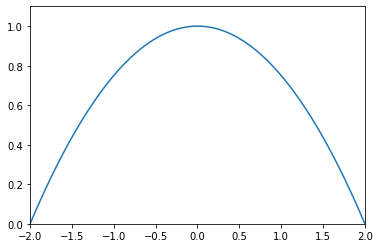

In [13]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = np.linspace(-2, 2, 100)
plt.xlim(-2, 2)
plt.ylim(0, 1.1)
plt.plot(x, 1-x**2/4)

This is the kernel that performs the classification. Next step is to perform the post-selection on observing 0 on the measurement on the ancilla and calculate the probabilities of the test instance belonging to either class:

In [14]:
def postselect(result_counts):
    total_samples = sum(result_counts.values())

    # define lambda function that retrieves only results where the ancilla is in the |0> state
    post_select = lambda counts: [(state, occurences) for state, occurences in counts.items() if state[-1] == '0']

    # perform the postselection
    postselection = dict(post_select(result_counts))
    postselected_samples = sum(postselection.values())

    print(f'Ancilla post-selection probability was found to be {postselected_samples/total_samples}')

    retrieve_class = lambda binary_class: [occurences for state, occurences in postselection.items() if state[0] == str(binary_class)]

    prob_class0 = sum(retrieve_class(0))/postselected_samples
    prob_class1 = sum(retrieve_class(1))/postselected_samples

    print('Probability for class 0 is', prob_class0)
    print('Probability for class 1 is', prob_class1)

This gives the results for the first instance as follows:

In [15]:
circuit_0 = interfere_data_and_test_instances(state_preparation_0, q, c, angles)
job = execute(circuit_0, backend)
result = job.result()
postselect(result.get_counts(circuit_0))

Ancilla post-selection probability was found to be 0.7392578125
Probability for class 0 is 0.6605019815059445
Probability for class 1 is 0.3394980184940555


And for the second one:

In [16]:
angles = [test_angles[1], training_angle]
state_preparation_1 = prepare_state(q, c, angles)
circuit_1 = interfere_data_and_test_instances(state_preparation_1, q, c, angles)
job = execute(circuit_1, backend)
result = job.result()
postselect(result.get_counts(circuit_1))

Ancilla post-selection probability was found to be 0.9140625
Probability for class 0 is 0.5288461538461539
Probability for class 1 is 0.47115384615384615


# References

[95] M. Schuld, M. Fingerhuth, F. Petruccione. (2017). [Implementing a distance-based classifier with a quantum interference circuit](https://doi.org/10.1209/0295-5075/119/60002). *Europhysics Letters*, 119(6), 60002. <a id='1'></a>